In [1]:
import sys
sys.path.append('../')  # for gpflow-old-0.5 and safe_learning folders



In [ ]:

%cd ../ # check if you are at the root folder of the project \safe-learning\

d:\USER DATA C DRIVE\Documents\codingProjects\random\safe_learning


In [22]:
%pip install  ./safe_learning
%pip install  ./gpflow-old-0.5
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


ERROR: Directory './safe_learning' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


Processing d:\user data c drive\documents\codingprojects\random\safe_learning\examples\gpflow-old-0.5
  Created wheel for gpflow-old: filename=gpflow_old-0.5-py3-none-any.whl size=78238 sha256=0fdcdceac932049c8ae66226868060a5e21aa8d6e5e2786dd72e3148ee10397b
  Stored in directory: c:\users\gamer\appdata\local\pip\cache\wheels\a6\b2\d8\c7d133e33599740bff8a4d26d660eb3413bf878135b65fcdf4Note: you may need to restart the kernel to use updated packages.
Successfully built gpflow-old
  Attempting uninstall: gpflow-old



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


    Found existing installation: gpflow-old 0.5
    Uninstalling gpflow-old-0.5:
      Successfully uninstalled gpflow-old-0.5
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement gpflow==0.5.0 (from versions: 1.4.1.linux-x86_64, 1.5.0.linux-x86_64, 1.0.0, 1.1.0, 1.1.1, 1.2.0, 1.3.0, 1.4.1, 1.5.0, 1.5.1, 2.0.0rc1, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.2.0, 2.2.1, 2.3.0, 2.3.1, 2.4.0)
ERROR: No matching distribution found for gpflow==0.5.0


In [1]:
from __future__ import division, print_function

from functools import partial

import gpflow
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal, linalg

# Nice progress bars


try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x


import safe_learning
import plotting
from utilities import InvertedPendulum

%matplotlib inline

# Open a new session (close old one if exists)
try:
    session.close()
except NameError:
    pass

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# get tf version
print(tf.__version__)

1.15.0


In [3]:
import cvxpy

print(cvxpy.__version__)


1.1.12


# Define underlying dynamic system and costs/rewards
Define the dynamics of the true and false system


In [4]:
n = 2
m = 1

# 'Wrong' model parameters
mass = 0.1
friction = 0.
length = 0.5
gravity = 9.81
inertia = mass * length ** 2

# True model parameters
true_mass = 0.15
true_friction = 0.1
true_length = length
true_inertia = true_mass * true_length ** 2

# Input saturation
x_max = np.deg2rad(30)
u_max = gravity * true_mass * true_length * np.sin(x_max)

# Normalization
norm_state = np.array([x_max, np.sqrt(gravity / length)])
norm_action = np.array([u_max])

# Corresponding dynamic systems
true_dynamics = InvertedPendulum(mass=true_mass, length=true_length, friction=true_friction,
                                 normalization=(norm_state, norm_action))

wrong_pendulum = InvertedPendulum(mass=mass, length=length, friction=friction,
                                  normalization=(norm_state, norm_action))

# LQR cost matrices
q = 1 * np.diag([1., 2.])
r = 1.2 * np.array([[1]], dtype=safe_learning.config.np_dtype)

# Quadratic (LQR) reward function
gamma = 0.98
reward_function = safe_learning.QuadraticFunction(linalg.block_diag(-q, -r))

# Set up a discretization for safety verification

In [5]:
# x_min, x_max, discretization\
state_limits = np.array([[-2., 2.], [-1.5, 1.5]])
action_limits = np.array([[-1, 1]])
num_states = [2001, 1501]

safety_disc = safe_learning.GridWorld(state_limits, num_states)
policy_disc = safe_learning.GridWorld(state_limits, [55, 55])

# Discretization constant
tau = np.min(safety_disc.unit_maxes)

print('Grid size: {0}'.format(safety_disc.nindex))

Grid size: 3003501


# Define the GP dynamics model

We use a combination of kernels to model the errors in the dynamics

In [6]:
A, B = wrong_pendulum.linearize()
lipschitz_dynamics = 1

noise_var = 0.001 ** 2

m_true = np.hstack((true_dynamics.linearize()))
m = np.hstack((A, B))

variances = (m_true - m) ** 2

# Make sure things remain 
np.clip(variances, 1e-5, None, out=variances)

# Kernels
kernel1 = (gpflow.kernels.Linear(3, variance=variances[0, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[0, 1]))

kernel2 = (gpflow.kernels.Linear(3, variance=variances[1, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[1, 1]))

# Mean dynamics

mean_dynamics = safe_learning.LinearSystem((A, B), name='mean_dynamics')
mean_function1 = safe_learning.LinearSystem((A[[0], :], B[[0], :]), name='mean_dynamics_1')
mean_function2 = safe_learning.LinearSystem((A[[1], :], B[[1], :]), name='mean_dynamics_2')

# Define a GP model over the dynamics
gp1 = gpflow.gpr.GPR(np.empty((0, 3), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel1,
                    mean_function=mean_function1)
gp1.likelihood.variance = noise_var

gp2 = gpflow.gpr.GPR(np.empty((0, 3), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel2,
                    mean_function=mean_function2)
gp2.likelihood.variance = noise_var

gp1_fun = safe_learning.GaussianProcess(gp1)
gp2_fun = safe_learning.GaussianProcess(gp2)

dynamics = safe_learning.FunctionStack((gp1_fun, gp2_fun))

/app/safe_learning/functions.py:1563: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.matrix = np.hstack(map(fun, matrices))


In [7]:
# Compute the optimal policy for the linear (and wrong) mean dynamics
k, s = safe_learning.utilities.dlqr(A, B, q, r)
init_policy = safe_learning.LinearSystem((-k), name='initial_policy')
init_policy = safe_learning.Saturation(init_policy, -1, 1)

# Define the Lyapunov function corresponding to the initial policy
init_lyapunov = safe_learning.QuadraticFunction(s)

# Set up the dynamic programming problem

In [8]:
# Define a neural network policy
relu = tf.nn.relu
policy = safe_learning.NeuralNetwork(layers=[32, 32, 1],
                                     nonlinearities=[relu, relu, tf.nn.tanh],
                                     output_scale=action_limits[0, 1])

# Define value function approximation
value_function = safe_learning.Triangulation(policy_disc,
                                             -init_lyapunov(policy_disc.all_points).eval(),
                                             project=True)

# Define policy optimization problem
rl = safe_learning.PolicyIteration(
    policy,
    dynamics,
    reward_function,
    value_function,
    gamma=gamma)
    

with tf.name_scope('rl_mean_optimization'):
    rl_opt_value_function = rl.optimize_value_function()
    
    # Placeholder for states
    tf_states_mean = tf.placeholder(safe_learning.config.dtype, [None, 2])
    
    # Optimize for expected gain
    values = rl.future_values(tf_states_mean)
    policy_loss = -tf.reduce_mean(values)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    adapt_policy_mean = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)




Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





/app/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
# Start the session
session.run(tf.global_variables_initializer())

### Run initial dynamic programming for the mean dynamics

In [10]:
for i in tqdm(range(3000)):
    
    # select random training batches
    rl.feed_dict[tf_states_mean] = policy_disc.sample_continuous(1000)

    session.run(adapt_policy_mean, feed_dict=rl.feed_dict)

# Define the Lyapunov function

Here we use the fact that the optimal value function is a Lyapunov function for the optimal policy if the dynamics are deterministic. As uncertainty about the dynamics decreases, the value function for the mean dynamics will thus converge to a Lyapunov function.

In [11]:
lyapunov_function = -rl.value_function
lipschitz_lyapunov = lambda x: tf.reduce_max(tf.abs(rl.value_function.gradient(x)),
                                             axis=1, keepdims=True)

lipschitz_policy = lambda x: policy.lipschitz() 

a_true, b_true = true_dynamics.linearize()
lipschitz_dynamics = lambda x: np.max(np.abs(a_true)) + np.max(np.abs(b_true)) * lipschitz_policy(x)

# Lyapunov function definitial
lyapunov = safe_learning.Lyapunov(safety_disc,
                                  lyapunov_function,
                                  dynamics,
                                  lipschitz_dynamics,
                                  lipschitz_lyapunov,
                                  tau,
                                  policy=rl.policy,
                                  initial_set=None)

# Set initial safe set (level set) based on initial Lyapunov candidate
values = init_lyapunov(safety_disc.all_points).eval()
cutoff = np.max(values) * 0.005

lyapunov.initial_safe_set = np.squeeze(values, axis=1) <= cutoff

/app/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


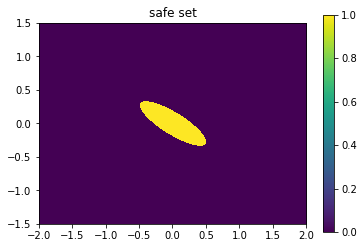

In [12]:
def plot_safe_set(lyapunov, show=True):
    """Plot the safe set for a given Lyapunov function."""
    plt.imshow(lyapunov.safe_set.reshape(num_states).T,
               origin='lower',
               extent=lyapunov.discretization.limits.ravel(),
               vmin=0,
               vmax=1)
    
    if isinstance(lyapunov.dynamics, safe_learning.UncertainFunction):
        X = lyapunov.dynamics.functions[0].X
        plt.plot(X[:, 0], X[:, 1], 'rx')
    
    plt.title('safe set')
    plt.colorbar()
    if show:
        plt.show()
    
lyapunov.update_safe_set()
plot_safe_set(lyapunov)

## Safe policy update

We do dynamic programming, but enfore the decrease condition on the Lyapunov function using a Lagrange multiplier

In [13]:
with tf.name_scope('policy_optimization'):
    
    # Placeholder for states
    tf_states = tf.placeholder(safe_learning.config.dtype, [None, 2])
    
    # Add Lyapunov uncertainty (but only if safety-relevant)
    values = rl.future_values(tf_states, lyapunov=lyapunov)
    
    policy_loss = -tf.reduce_mean(values)
    

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    adapt_policy = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)
    
    
def rl_optimize_policy(num_iter):
    # Optimize value function
    session.run(rl_opt_value_function, feed_dict=rl.feed_dict)

    # select random training batches
    for i in tqdm(range(num_iter)):
        rl.feed_dict[tf_states] = lyapunov.discretization.sample_continuous(1000)

        session.run(adapt_policy, feed_dict=rl.feed_dict)

/usr/local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Exploration

We explore close to the current policy by sampling the most uncertain state that does not leave the current level set

In [14]:
action_variation = np.array([[-0.02], [0.], [0.02]], dtype=safe_learning.config.np_dtype)


with tf.name_scope('add_new_measurement'):
        action_dim = lyapunov.policy.output_dim
        tf_max_state_action = tf.placeholder(safe_learning.config.dtype,
                                             shape=[1, safety_disc.ndim + action_dim])
        tf_measurement = true_dynamics(tf_max_state_action)
        
def update_gp():
    """Update the GP model based on an actively selected data point."""
    # Get a new sample location
    max_state_action, _ = safe_learning.get_safe_sample(lyapunov,
                                                        action_variation,
                                                        action_limits,
                                                        num_samples=1000)

    # Obtain a measurement of the true dynamics
    lyapunov.feed_dict[tf_max_state_action] = max_state_action
    measurement = tf_measurement.eval(feed_dict=lyapunov.feed_dict)

    # Add the measurement to our GP dynamics
    lyapunov.dynamics.add_data_point(max_state_action, measurement)
    

# Run the optimization

/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


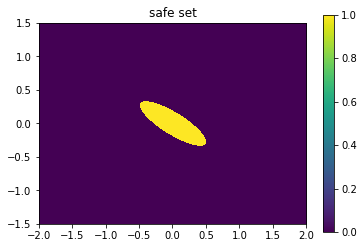

In [15]:
# lyapunov.update_safe_set()
rl_optimize_policy(num_iter=200)
rl_optimize_policy(num_iter=200)

lyapunov.update_safe_set()
plot_safe_set(lyapunov)

iteration 0 with c_max: 33.24701466178033


/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(msg, UserWarning)


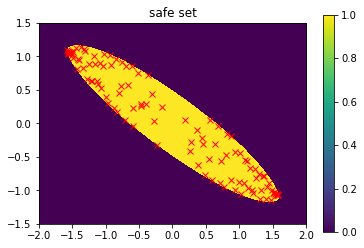

iteration 1 with c_max: 33.19979458462319


/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarning)


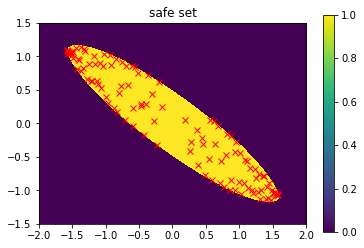

iteration 2 with c_max: 33.15422918945411


/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 19 times so far.

  warnings.warn(msg, UserWarning)


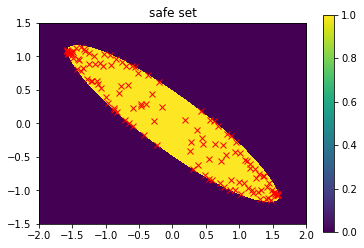

iteration 3 with c_max: 33.16254972903538


/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 20 times so far.

  warnings.warn(msg, UserWarning)


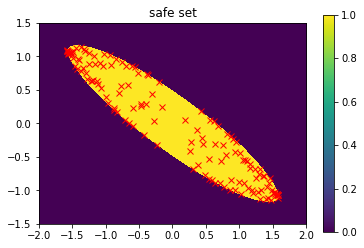

iteration 4 with c_max: 33.181581370636344


/usr/local/lib/python3.6/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 21 times so far.

  warnings.warn(msg, UserWarning)


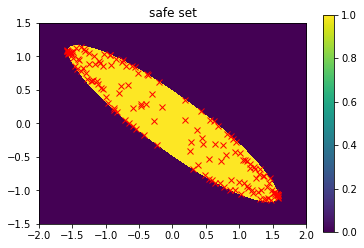

In [34]:
for i in range(5):
    print('iteration {} with c_max: {}'.format(i, lyapunov.feed_dict[lyapunov.c_max]))
    for i in tqdm(range(10)):
        update_gp()
    
    rl_optimize_policy(num_iter=200)
    lyapunov.update_values()
    
    # Update safe set and plot
    lyapunov.update_safe_set()
    plot_safe_set(lyapunov)    

# Plot trajectories and analyse improvement

In [16]:
x0 = np.array([[1., -.5]])

states_new, actions_new = safe_learning.utilities.compute_trajectory(true_dynamics, rl.policy, x0, 100)
states_old, actions_old = safe_learning.utilities.compute_trajectory(true_dynamics, init_policy, x0, 100)

t = np.arange(len(states_new)) * true_dynamics.dt

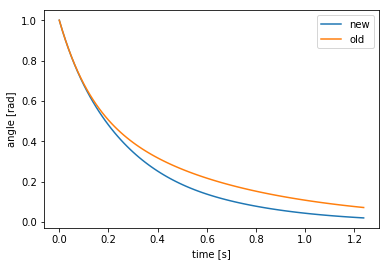

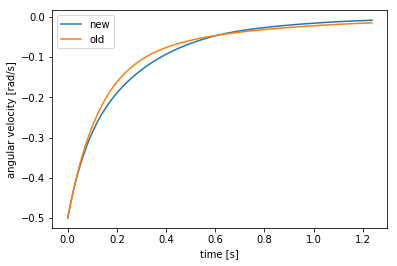

In [17]:
plt.plot(t, states_new[:, 0], label='new')
plt.plot(t, states_old[:, 0], label='old')
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')
plt.legend()
plt.show()

plt.plot(t, states_new[:, 1], label='new')
plt.plot(t, states_old[:, 1], label='old')
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rad/s]')
plt.legend()
plt.show()

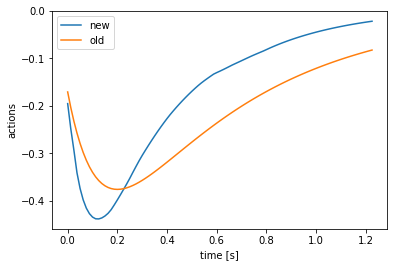

In [18]:
plt.plot(t[:-1], actions_new, label='new')
plt.plot(t[:-1], actions_old, label='old')
plt.xlabel('time [s]')
plt.ylabel('actions')
plt.legend()

In [19]:
print('reward old:', tf.reduce_sum(rl.reward_function(states_old[:-1], actions_old)).eval(feed_dict=rl.feed_dict))
print('reward new:', tf.reduce_sum(rl.reward_function(states_new[:-1], actions_new)).eval(feed_dict=rl.feed_dict))

reward old: -24.690588894211565
reward new: -21.658848419456625


/app/safe_learning/utilities.py:152: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  concatenated = (np.hstack(to_concatenate),)
